<a href="https://colab.research.google.com/github/lphuong304/CS114.L21/blob/main/COLAB_ASSIGNMENTS/COLAB_ASSIGNMENT_17_05/PREDICT_FINAL_SCORE_OF_IT001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><b>BÀI TẬP COLAB SỐ 03 - 17/05/2021</b></h1>
<h1 align="center"><b>PREDICT FINAL SCORE OF IT001</b></h1>

---

###LỚP: CS114.L21
###NHÓM:
1. Nguyễn Ngọc Lan Phương - *19520227*
2. Hoàng Anh Tú - *19522450*
3. Nguyễn Quốc Huy - *19521623*

Nguồn tham khảo:
* [Regularizing Linear Regression Models](https://blog.quantinsti.com/linear-regression-models-scikit-learn/)
* [PolyminalFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)



Link data:
* Data wecode: [link](https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/wecode.csv)
* Data score: [link](https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/wecode.csv)


References:
1. [Import Packages and Discovery and Visualize Data](#part1)
2. [Pre-processing Data and Show the Correlation of the features](#process)
3. [Traning Model and Testing](#model)
4. [Nhận xét](#nhanxet)


#1. Import Packages Import Package and Discovery and Visualize Data
<a name = 'part1'></a>

## 1.1 Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  accuracy_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

## 1.2 Data Discovery

In [2]:
data_score = pd.read_csv('https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/score_training.csv')
data = pd.read_csv('https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/wecode.csv')

In [3]:
data.head(5)

,id,assignment_id,problem_id,user_id,is_final,status,pre_score,coefficient,file_name,language_id,created_at,updated_at
0,4,0,3,4,1,SCORE,10000,100,solution-0,2,2020-10-30 10:58:11,2020-10-30 10:58:19
1,5,0,4,4,1,SCORE,10000,100,solution-1,2,2020-10-30 11:07:09,2020-10-30 11:07:17
2,6,0,5,4,0,Compilation Error,0,100,solution-2,2,2020-10-30 11:08:01,2020-10-30 11:23:36
3,7,0,5,4,0,Compilation Error,0,100,solution-3,2,2020-10-30 11:11:41,2020-10-30 11:11:42
4,8,0,5,4,0,Compilation Error,0,100,solution-4,2,2020-10-30 11:15:06,2020-10-30 11:15:07


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264606 entries, 0 to 264605
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             264606 non-null  int64 
 1   assignment_id  264606 non-null  int64 
 2   problem_id     264606 non-null  int64 
 3   user_id        264606 non-null  int64 
 4   is_final       264606 non-null  int64 
 5   status         264605 non-null  object
 6   pre_score      264606 non-null  int64 
 7   coefficient    264606 non-null  object
 8   file_name      264606 non-null  object
 9   language_id    264606 non-null  int64 
 10  created_at     264606 non-null  object
 11  updated_at     264606 non-null  object
dtypes: int64(7), object(5)
memory usage: 24.2+ MB


In [5]:
#tries - tổng số lần nộp của mỗi user_id, tính luôn đã submit và chưa submit, cả những lần nộp bài full điểm cà chưa full điểm
raw = pd.DataFrame({'tries' : data['user_id'].value_counts()})
raw = raw.sort_index()

In [6]:
# solved - số problem đã giải được của mỗi user_id => is_final = 1 và pre-score = 10000
user_isfinal_score = data[['user_id', 'is_final', 'pre_score']]

solvedData = user_isfinal_score[(user_isfinal_score['is_final'] > 0) & (user_isfinal_score['pre_score'] == 10000)].groupby('user_id').sum()

solvedData.drop('pre_score', axis=1, inplace=True)
solvedData.rename(columns={'is_final':'solved'}, inplace=True)

raw = pd.concat([raw, solvedData], axis=1)
raw = raw.fillna(0.0)


In [7]:
#num_problemSumbited - tổng số problem đã sumbit cuối cùng của mỗi user_id trên tổng số lần thử, những bài submit có thể full điểm và không full điểm

# array of user_id
list_userID = data['user_id'].tolist()
listStr_userID = data['user_id'].astype(str).tolist()

# array of assignment_id
list_assignmentID = data['assignment_id'].astype(str).tolist()

# array of problem_id
list_problemID = data['problem_id'].astype(str).tolist()
list_problemID
# connect user-assignment-problem
for i in range(len(list_assignmentID)):
  list_assignmentID[i] = listStr_userID[i] + ' ' + list_assignmentID[i] + ' ' + list_problemID[i]

list_assignmentID
dictData = {'user_id': list_userID,
        'num_problemSubmitted': list_assignmentID}

num_problemSumbitedDF = pd.DataFrame(dictData).set_index('user_id')
num_problemSumbitedDF
num_problemSumbitedDF = num_problemSumbitedDF.groupby('user_id').nunique()

raw = pd.concat([raw, num_problemSumbitedDF], axis=1)


In [8]:
#tổng điểm các bài được cuối cùng của mỗi user
user_isfinal_score = data[['user_id', 'is_final', 'pre_score']]

trueScore = user_isfinal_score[user_isfinal_score['is_final'] > 0].groupby('user_id').sum()
trueScore = trueScore.drop('is_final', axis=1)
trueScore.rename(columns={'pre_score':'total_FinalScore'}, inplace=True)

raw = pd.concat([raw, trueScore], axis=1)
raw

,tries,solved,num_problemSubmitted,total_FinalScore
1,2,1.0,2,10000.0
4,54,37.0,41,370000.0
5,6,3.0,5,30000.0
6,130,85.0,89,850000.0
7,5,0.0,2,9209.0
...,...,...,...,...
1860,76,28.0,48,329665.0
1862,12,4.0,6,40000.0
1864,187,28.0,63,439741.0
1865,99,10.0,17,116428.0


Giải thích ý nghĩa các features:
* Tries: số lần mà user_id xuất hiện trên data, đồng nghĩa là tổng số lần thử giải các problem (tính luôn cả chưa submit, submit và AC, submit và không AC)
* Solved: là số các problem được submit (is_final = 1, pre-score = 10000) của mỗi user_id đã được AC
* Submitted: số lần user_id submit các problem (tính luôn cả những bài submit AC và chưa AC)
* total_FinalScore: tổng điểm pre-score của user_id, tính luôn cả những bài đã AC và chưa AC.

=>Từ các features các bạn gợi ý trên ms team và kinh nghiệm học môn NMLT - IT001 chúng em nhận thấy các features trên sẽ có khả năng cao phản ánh được năng lực của học sinh chính xác hơn các features khác, từ đó dự đoán điểm CK của các user_id.

In [9]:
data_score['CK'] = pd.to_numeric(data_score['CK'], errors='coerce')
raw_ck = data_score['CK']

## 1.3 Data Visualization

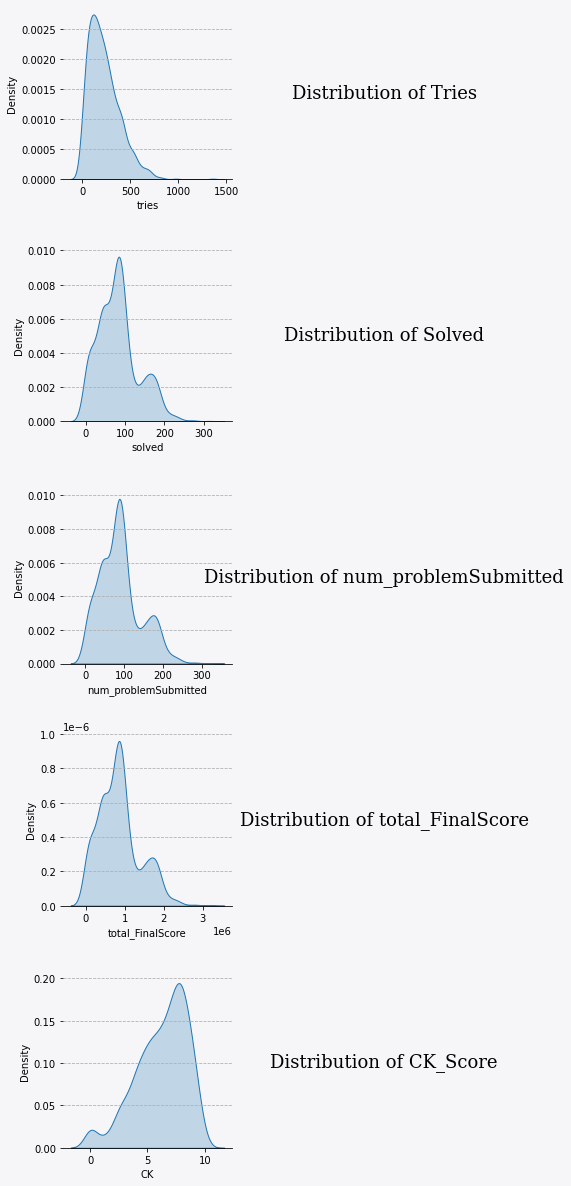

In [10]:
fig= plt.figure(figsize = (20,21))
gs = fig.add_gridspec(5,5)
gs.update(wspace=0.4, hspace=0.4)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,0])
ax9 = fig.add_subplot(gs[4,1])
axes=[ax0,ax1,ax2,ax3,ax4,ax5, ax6, ax7, ax8, ax9]
background_color = '#f6f5f7'

for i in axes:
    i.set_facecolor(background_color)
fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax = ax0, data=raw['tries'],shade=True,palette='rocket', label = 'tries') # Distributions
ax0.grid(linestyle='--', axis='y')
ax1.text(0.5,0.5,'Distribution of Tries',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax= ax2, data=raw['solved'],shade=True,palette='rocket', label = 'solved') # Distributions
ax2.grid(linestyle='--', axis='y')
ax3.text(0.5,0.5,'Distribution of Solved',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax = ax4, data=raw['num_problemSubmitted'],shade=True,palette='rocket', label = 'num_problemSubmitted') # Distributions
ax4.grid(linestyle='--', axis='y')
ax5.text(0.5,0.5,'Distribution of num_problemSubmitted',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax= ax6, data= raw['total_FinalScore'],shade=True,palette='rocket', label = 'total_FinalScore') # Distributions
ax6.grid(linestyle='--', axis='y')
ax7.text(0.5,0.5,'Distribution of total_FinalScore',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax= ax8, data = raw_ck,shade=True,palette='rocket', label = 'CK_Score') # Distributions
ax8.grid(linestyle='--', axis='y')
ax9.text(0.5,0.5,'Distribution of CK_Score',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')



axes1=[ax1,ax3,ax5,ax7,ax9]
for i in axes1:
    i.spines["bottom"].set_visible(False)
    i.spines["left"].set_visible(False)
    i.set_xlabel("")
    i.set_ylabel("")
    i.set_xticklabels([])
    i.set_yticklabels([])
    i.tick_params(left=False, bottom=False)
# removing spines of figures
for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)
    ax5.spines[i].set_visible(False)
    ax6.spines[i].set_visible(False)
    ax7.spines[i].set_visible(False)
    ax8.spines[i].set_visible(False)
    ax9.spines[i].set_visible(False)

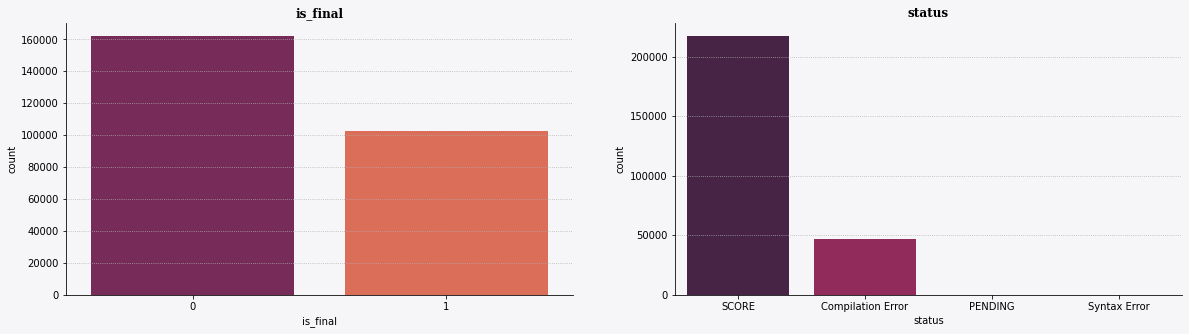

In [11]:
fig=plt.figure(figsize=(20,23))
background_color = '#f6f5f7'
fig.patch.set_facecolor(background_color) 
data_categorical = pd.concat([data['is_final'], data['status']], axis=1)
for indx,val in enumerate(data_categorical.columns):
    ax=plt.subplot(4,2,indx+1)
    ax.set_facecolor(background_color)
    ax.set_title(val,fontweight='bold',fontfamily='serif')
    for i in ['top','right']:
        ax.spines[i].set_visible(False)
    ax.grid(linestyle=':',axis='y')
    sns.countplot(data_categorical[val],palette='rocket')

Nhận xét dữ liệu:
* Điểm CK có sự phân bố không đồng đều, điểm từ khoảng 5 - 8 chiếm tỉ lệ nhiều nhất, chúng em dự đoán có thể nếu sử dụng data như trên thì model sẽ không dự đoán tốt các học sinh có khung điểm từ  9 - 10, nên cân nhắc sẽ bổ sung data sau bằng phương pháp over-sampling.
* Chỉ số Tries  trong khoảng từ 10 đến 300 là nhiều nhất, trong khi các problems được giải AC - solved phân phối nhiều trong khoảng từ 50 đến 150, xấp xỉ 1 nửa so với tries. Song song đó số bài hoàn thành bao gồm cả những bài không được AC - submitted thì có phân phối cao nhất trong khoảng từ 20 - 150
* finalScore phân bố nhiều trong khoảng từ 5e5 đến 2e6. 

In [12]:
# set type of element
raw = raw.astype(float)
raw

,tries,solved,num_problemSubmitted,total_FinalScore
1,2.0,1.0,2.0,10000.0
4,54.0,37.0,41.0,370000.0
5,6.0,3.0,5.0,30000.0
6,130.0,85.0,89.0,850000.0
7,5.0,0.0,2.0,9209.0
...,...,...,...,...
1860,76.0,28.0,48.0,329665.0
1862,12.0,4.0,6.0,40000.0
1864,187.0,28.0,63.0,439741.0
1865,99.0,10.0,17.0,116428.0


## 1.4 Create New Dataframe
Như đã nói ở trên, sau bước đầu lựa chọn các feature có khả năng dự đoán năng lực của một sinh viên để dự đoán điểm CK, chúng em sẽ tạo một DataFrame hoàn toàn mới chứa các feature trên dựa vào data wecode ban đầu.

In [13]:
#@title
#cell này Phưn hông có chạy
index = raw.index.tolist()
list_tries = raw['tries'].tolist()
list_solved = raw['solved'].tolist()
list_numProblemSumbited = raw['num_problemSubmitted'].values.tolist()

list_numProblemSumbited,list_solved
#Tổng pre_score của các submssion có is_final = 1
list_totalFinalScore = raw['total_FinalScore'].tolist()

# Tổng số problem đã solved (is_final = 1 && pre_score=10000) / Tổng số problem có submit = solved/submiited
solved_per_submitted = []
for i in range(len(index)):
  solved_per_submitted.append(list_solved[i] / list_numProblemSumbited[i])

#Tổng số problem đã solved (is_final = 1 && pre_score=10000) / Tổng số lần thử submit = solved/tries
solved_tries = []
for i in range(len(index)):
  solved_tries.append(list_solved[i] / list_tries[i])
# # Tổng số problem đã sumbit / Tổng số submissions ?? #xàm te :)) nó ra 1 mà :))
# # probSubmited_totalSubmit = []
# # for i in range(len(index)):
# #   probSubmited_totalSubmit.append(list_numProblemSumbited[i] / 264606)

In [14]:
dict_newData = {'index': index,
                    'tries': list_tries,
                    'solved': list_solved,
                    'submited': list_numProblemSumbited,
                    'solved/tries': solved_tries,
                    'solved/submited': solved_per_submitted,
                    'finalScore': list_totalFinalScore
}

newDF = pd.DataFrame(dict_newData).set_index('index')
newDF

,tries,solved,submited,solved/tries,solved/submited,finalScore
index,,,,,,
1,2.0,1.0,2.0,0.500000,0.500000,10000.0
4,54.0,37.0,41.0,0.685185,0.902439,370000.0
5,6.0,3.0,5.0,0.500000,0.600000,30000.0
6,130.0,85.0,89.0,0.653846,0.955056,850000.0
7,5.0,0.0,2.0,0.000000,0.000000,9209.0
...,...,...,...,...,...,...
1860,76.0,28.0,48.0,0.368421,0.583333,329665.0
1862,12.0,4.0,6.0,0.333333,0.666667,40000.0
1864,187.0,28.0,63.0,0.149733,0.444444,439741.0


Tạo thêm 2 feature mới để đánh giá khả năng giải quyết bài toán của sinh viên, cụ thể là:
* solved/tries: số các problem được AC trên tổng số lần thử của một user_id.
* solved/submitted: số các problem được AC trên tổng số các problem được submit

In [15]:
score_CK = data_score[['id', 'CK']]
score_CK.set_index('id', inplace=True)
new_data = pd.concat([newDF, score_CK], axis=1)
new_data.head(10).T

,1,4,5,6,7,11,14,15,20,22
tries,2.0,54.000000,6.0,130.000000,5.0,50.000000,22.000000,101.000000,13.000000,NaN
solved,1.0,37.000000,3.0,85.000000,0.0,9.000000,6.000000,45.000000,12.000000,NaN
submited,2.0,41.000000,5.0,89.000000,2.0,19.000000,7.000000,52.000000,12.000000,NaN
solved/tries,0.5,0.685185,0.5,0.653846,0.0,0.180000,0.272727,0.445545,0.923077,NaN
solved/submited,0.5,0.902439,0.6,0.955056,0.0,0.473684,0.857143,0.865385,1.000000,NaN
finalScore,10000.0,370000.000000,30000.0,850000.000000,9209.0,100316.000000,68000.000000,458666.000000,120000.000000,NaN
CK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.5


#2. Pre-processing Data and Show the Correlation of the features
<a name = 'process'></a>

## 2.1 Handling Missing Values in Data

Sau khi kết hợp với cột điểm CK theo user_id, chúng em nhận thấy dữ liệu bị thiếu NaN khá nhiều, nên thay vì loại bỏ các dữ liệu thiếu đó dẫn đến gây mất thông tin. Chúng em sẽ "lấp" các dữ liệu đó bằng phép nội suy tuyến tính và điền trung bình theo cột. (trừ cột CK, vì sẽ được đem đi predict)

In [16]:
#find NaN values and replace it with 0
def count_missing_values(data):
  num_of_miss_data = data.isnull().sum()
  missing_data = pd.concat([num_of_miss_data], axis=1, keys = ['Number of missing value'])
  return missing_data
count_missing_values(new_data)

,Number of missing value
tries,122
solved,122
submited,122
solved/tries,122
solved/submited,122
finalScore,124
CK,361


In [17]:
#fill missing value of column 'tries'
new_data['tries'] = new_data['tries'].interpolate(method = 'pad', limit = 3)
new_data['tries'] = new_data['tries'].fillna(int(np.mean(new_data['tries'])))

In [18]:
#fill missing value of column 'solved'
new_data['solved'] = new_data['solved'].interpolate(method = 'pad', limit = 3)
new_data['solved'] = new_data['solved'].fillna(int(np.mean(new_data['solved'])))

In [19]:
#fill missing value of column 'summited'
new_data['submited'] = new_data['submited'].interpolate(method = 'pad', limit = 3)
new_data['submited'] = new_data['submited'].fillna(int(np.mean(new_data['submited'])))

In [20]:
new_data['solved/tries'] = new_data['solved'] / new_data['tries'] 
new_data['solved/submited'] = new_data['solved'] / new_data['submited'] 

In [21]:
new_data['finalScore'] = new_data['finalScore'].interpolate(method = 'pad', limit = 3)
new_data['finalScore'] = new_data['finalScore'].fillna(int(np.mean(new_data['finalScore'])))

* Chia data frame vừa mới tạp thành hai tập **data_to_train** (các user_id đã có điểm CK) và **data_to_predict** (các user_id chưa có điểm CK và cần phải predict). 
* Loại bỏ các hàng sau khi xử lí dữ liệu thiếu không khớp với thông tin thực tế như hai chỉ số **solved/tries > 1** và **solved/submitted** > 1.

In [22]:
data_to_predict = new_data[new_data.isna().any(axis=1)]
data_to_predict = data_to_predict[data_to_predict['solved/tries'] <= 1]
data_to_predict = data_to_predict[data_to_predict['solved/submited'] <= 1]
data_to_predict

,tries,solved,submited,solved/tries,solved/submited,finalScore,CK
1,2.0,1.0,2.0,0.500000,0.500000,10000.0,NaN
4,54.0,37.0,41.0,0.685185,0.902439,370000.0,NaN
5,6.0,3.0,5.0,0.500000,0.600000,30000.0,NaN
6,130.0,85.0,89.0,0.653846,0.955056,850000.0,NaN
7,5.0,0.0,2.0,0.000000,0.000000,9209.0,NaN
...,...,...,...,...,...,...,...
1852,20.0,1.0,1.0,0.050000,1.000000,10000.0,NaN
1855,134.0,63.0,67.0,0.470149,0.940299,649000.0,NaN
1860,76.0,28.0,48.0,0.368421,0.583333,329665.0,NaN
1864,187.0,28.0,63.0,0.149733,0.444444,439741.0,NaN


In [23]:
#lưu id của các user cần predict điểm ck, sẽ sử dụng sau.
id_predict = data_to_predict.index.to_numpy()

In [24]:
data_to_train = new_data.dropna()
data_to_train = data_to_train[data_to_train['solved/tries'] <= 1]
data_to_train = data_to_train[data_to_train['solved/submited'] <= 1]

In [25]:
data_to_train.describe()

,tries,solved,submited,solved/tries,solved/submited,finalScore,CK
count,920.000000,920.000000,920.000000,920.000000,920.000000,9.200000e+02,920.000000
mean,240.764130,86.750000,93.559783,0.385580,0.884055,8.952187e+05,6.192935
std,167.205639,52.366214,53.692214,0.147076,0.164510,5.338194e+05,2.238136
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,121.000000,50.750000,58.000000,0.298419,0.875000,5.288322e+05,5.000000
50%,212.000000,83.000000,87.000000,0.380045,0.936506,8.479760e+05,6.500000
75%,323.250000,105.250000,113.000000,0.470021,0.971305,1.086106e+06,8.000000
max,1359.000000,314.000000,319.000000,0.923077,1.000000,3.168763e+06,10.000000


##2.2 Show the Correlation of  Features
Sau các bước tiền xử lý dữ liệu cơ bản như trên, chúng em sẽ tiến hành lọc các feature một lần nữa bằng cách **trực quan hóa mối quan hệ giữa chúng đối với điểm CK** (bằng *Scatter Plot*)  và thể hiện sự tương quan giữa các feature (bằng *Correlation Matrix*)

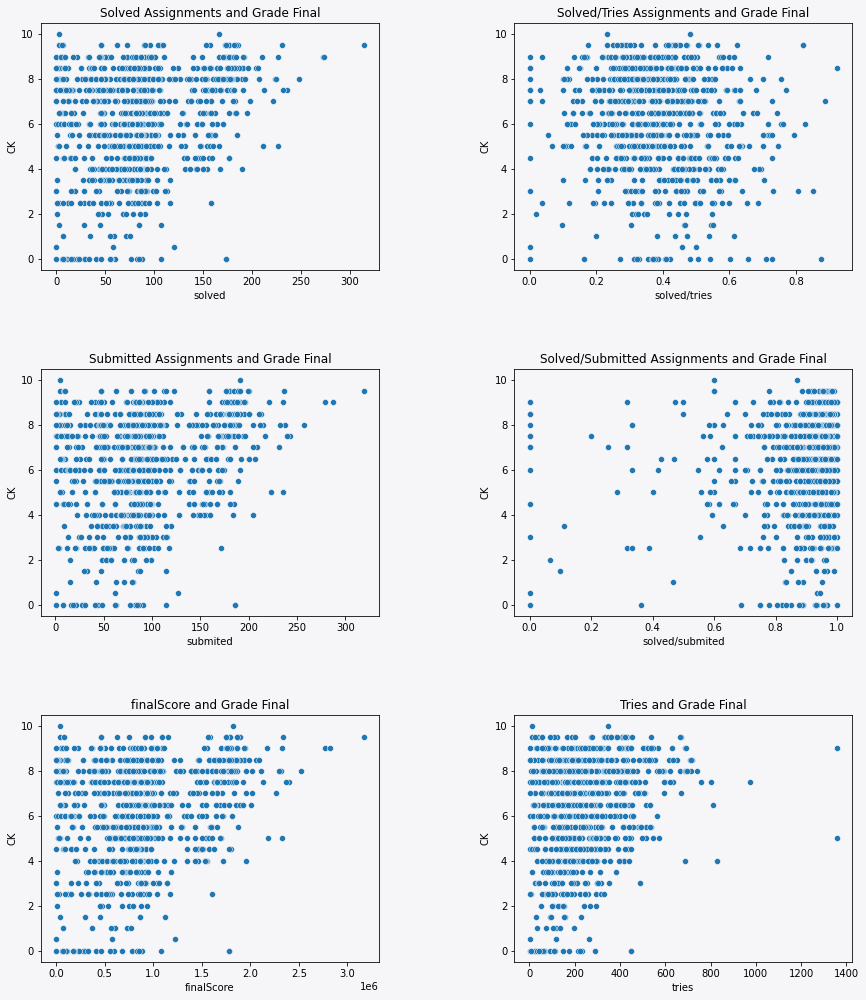

In [26]:
fig= plt.figure(figsize = (40,30))
gs1 = fig.add_gridspec(3,3)
gs1.update(wspace=0.4, hspace=0.4)

axs0 = fig.add_subplot(gs[0,0])
axs1 = fig.add_subplot(gs[0,1])
axs2 = fig.add_subplot(gs[1,0])
axs3 = fig.add_subplot(gs[1,1])
axs4 = fig.add_subplot(gs[2,0])
axs5 = fig.add_subplot(gs[2,1])
axes=[axs0,axs1,axs2,axs3,axs4, axs5]
background_color = '#f6f5f7'

for i in axes:
    i.set_facecolor(background_color)
fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs0, x = data_to_train['solved'], y = data_to_train['CK'].sort_values() )
axs0.set_title('Solved Assignments and Grade Final')

fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs1, x = data_to_train['solved/tries'], y = data_to_train['CK'].sort_values())
axs1.set_title('Solved/Tries Assignments and Grade Final')

fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs2,x = data_to_train['submited'], y = data_to_train['CK'].sort_values())
axs2.set_title('Submitted Assignments and Grade Final')

fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs3,x = data_to_train['solved/submited'], y = data_to_train['CK'].sort_values())
axs3.set_title('Solved/Submitted Assignments and Grade Final')

fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs4,x = data_to_train['finalScore'], y = data_to_train['CK'].sort_values())
axs4.set_title('finalScore and Grade Final')

fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs5,x = data_to_train['tries'], y = data_to_train['CK'].sort_values())
axs5.set_title('Tries and Grade Final')

plt.show()

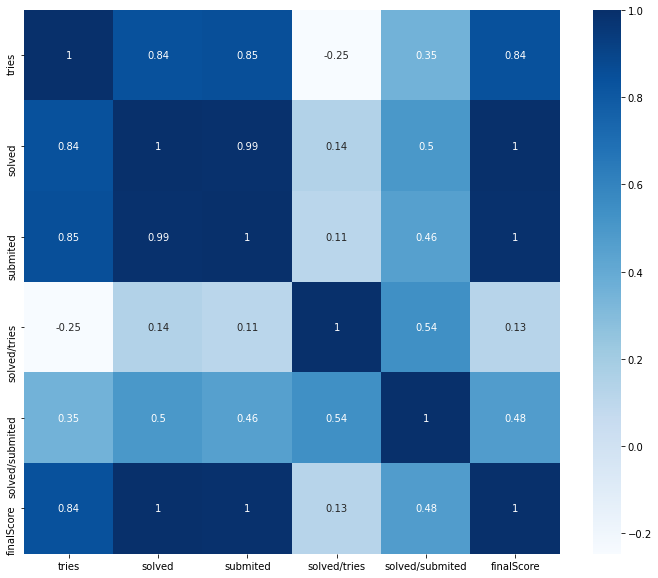

In [27]:
data_to_cor = data_to_train.iloc[:,data_to_train.columns!='CK']
plt.figure(figsize=(12,10))
cor = data_to_cor.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

###**Nhận xét**:
+ Các features như **solved/tries**, **solved/submitted** có scatter plot trải đều, không theo quy luật, nhưng chúng em đã thử và khi bỏ hai cột feature trên, model dự đoán kém chính xác hơn so với lúc giữ hai cột feature.
+ Các features như **tries, solved, submitted, finalScore** có scatter plot thể hiện được mối quan hệ giữa chúng với điểm CK khá tương đồng nhau, số lần **tries, solved, submitted** và **finalScore** ***càng cao*** thì điểm CK của user_id ***càng cao***
+ Correlation giữa các feature trong bộ data frame cho thấy có 4 feature có mức độ tương quan với nhau tương đối cao **tries, solved, submitted, finalScore**, theo lý thuyết, chúng em sẽ bỏ 2 và giữ 2.

=> Sau rất nhiều lần thử và dựa vào các phân tích trên, chúng em sẽ loại bỏ hai features là ***tries và solved***

In [28]:
data_to_train = data_to_train.drop(['tries','solved'], axis = 1)
data_to_predict = data_to_predict.drop(['tries','solved'], axis = 1)

In [29]:

data_to_train.describe()

,submited,solved/tries,solved/submited,finalScore,CK
count,920.000000,920.000000,920.000000,9.200000e+02,920.000000
mean,93.559783,0.385580,0.884055,8.952187e+05,6.192935
std,53.692214,0.147076,0.164510,5.338194e+05,2.238136
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,58.000000,0.298419,0.875000,5.288322e+05,5.000000
50%,87.000000,0.380045,0.936506,8.479760e+05,6.500000
75%,113.000000,0.470021,0.971305,1.086106e+06,8.000000
max,319.000000,0.923077,1.000000,3.168763e+06,10.000000


* Như đã nói ở trên, điểm CK của các user_id trong khoảng điểm từ 9 - 10 rất ít nên có thể model sẽ không nắm bắt được tốt data khi user_id có số điểm như trên. Nên chúng em tiến hàng tăng dữ liệu liên quan tới khoảng điểm ít xuất hiện nhất của user_id bằng phương pháp OverSampling và ở đây chúng em sử dụng hàm SMOTE.
* Cre tham khảo: [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

In [30]:
def Oversampling(mode="SMOTE"):
  if mode == 'SMOTE':
    oversample = SMOTE(sampling_strategy='minority', k_neighbors=1)
    X, y = oversample.fit_sample(data_to_train.loc[:,data_to_train.columns!='CK'], data_to_train['CK'])
  elif mode == 'Borderline':
    oversample = BorderlineSMOTE()
    X, y = oversample.fit_sample(data_to_train.loc[:,data_to_train.columns!='CK'], data_to_train['CK'])
  elif mode == 'SVMSMOTE':
    oversample = SVMSMOTE()
    X, y = oversample.fit_sample(data_to_train.loc[:,data_to_train.columns!='CK'], data_to_train['CK'])
  elif mode == 'ADASYN':
    oversample = ADASYN()
    X, y = oversample.fit_sample(data_to_train.loc[:,data_to_train.columns!='CK'], data_to_train['CK'])

  return X, y

In [31]:
X, y = Oversampling('SMOTE')
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (1022, 4)
Shape of y: (1022,)


* Dữ liệu được tạp thêm nên từ shape của tập dữ liệu X ban đầu *(920, 4)*, chúng em được một tập dữ liệu X mới có kích thước *(1022, 4)*.

In [32]:
data_to_train.to_csv('/content/data_train.csv')
data_to_predict.to_csv('/content/data_test.csv')

In [33]:
# X = data_to_train.iloc[:,data_to_train.columns!='CK']
# y = data_to_train.iloc[:,-1]
# # X = np.array(data_to_train['finalScore']).reshape(-1,1)
# # y = data_to_train['CK']
# X

* Bước tiếp theo chúng em chia dữ liệu từ tập X đã được xử lý ở trên thành hai bộ dữ liệu để train và để test theo tỷ lệ 80 - 20.
* Sau đó chúng em scale hai tập dữ liệu trên bằng hàm StanderScaler() của sklearn
* Để model nắm bắt train dữ liệu tốt hơn nữa, em sử dụng PolynomialFeatures để làm tăng feature cho bộ data từ feature ban đầu bằng phương pháp số mũ.

* Cre tham khảo : [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
x_train

array([[1.38000000e+02, 5.35269710e-01, 9.34782609e-01, 1.29500000e+06],
       [4.80000000e+01, 3.40909091e-01, 6.25000000e-01, 3.00000000e+05],
       [7.80000000e+01, 5.55555556e-01, 9.61538462e-01, 7.58888000e+05],
       ...,
       [1.09000000e+02, 1.30381304e-01, 9.72477064e-01, 1.06900000e+06],
       [7.20000000e+01, 4.83333333e-01, 8.05555556e-01, 6.46057000e+05],
       [8.40000000e+01, 6.29921260e-01, 9.52380952e-01, 8.03000000e+05]])

In [35]:
def normalize_train_test(X_train, X_test, raw_X, mode="StandardScaler"):
  if mode == "StandardScaler":
    scaler = StandardScaler()
  elif mode == "MinMaxScaler":
    scaler = MinMaxScaler()
  elif mode == "RobustScaler":
    scaler = RobustScaler()

  scaler = scaler.fit(X_train)
  
  X_train_std = scaler.transform(X_train)
  X_test_std = scaler.transform(X_test)
  raw_X_std = scaler.transform(raw_X)

  return scaler, X_train_std, X_test_std, raw_X_std

In [36]:
scaler, X_train_std, X_test_std, X_std = normalize_train_test(x_train, x_test, X, mode="StandardScaler")

In [37]:
poly = PolynomialFeatures(2)
x_train_poly = poly.fit_transform(X_train_std)
x_test_poly = poly.transform(X_test_std)

#3 Building Model to Predict and Testing
<a name = 'model'></a>
* Sử dụng Ridge Regression để tạo model từ các tập dữ liệu đã qua các bước tiền xử lý trên.
* Predict điểm CK cho các user_id chưa có điểm CK bằng model vừa train.

## Bulding Model
* Tìm tham số thích hợp nhất cho model bằng cách dùng hàm GridSearchCV của sklearn.

In [38]:

from sklearn.model_selection import GridSearchCV

alpha_values = {'alpha':[0.001, 0.01,0.02,0.03,0.04, 0.05, 0.06,0.07, 0.08, 0.1]}

ridge= GridSearchCV(Ridge(), alpha_values, scoring='neg_mean_squared_error', cv=10 )

print('The best value of alpha is:',ridge.fit(x_train_poly,y_train).best_params_)

print('The best score for the best Lasso estimator is:',ridge.fit(x_train_poly,y_train).best_score_)

The best value of alpha is: {'alpha': 0.1}
The best score for the best Lasso estimator is: -5.670390576773611


In [39]:
def train_model(X_train, y_train, mode = "Ridge"):
  if mode == "LinearRegression":
    model = LinearRegression()
  elif mode == "Ridge":
    model = Ridge()
  elif mode == "Lasso":
    model = Lasso()

  model.fit(X_train, y_train)

  return model

def predict_model(model, X_test):
  y_logit = model.predict(X_test)

  return y_logit

In [40]:
model  = Ridge(alpha = 0.1).fit(x_train_poly, y_train)
prediction = predict_model(model, x_test_poly)
prediction = prediction*2.0
prediction = prediction.astype(int)
prediction = np.round_(prediction/2, decimals=1, out=None)
prediction

array([ 6.5,  6. ,  6.5,  5. ,  6. ,  6. ,  6. ,  6. , 10. ,  7. ,  6.5,
        4. ,  4. ,  6.5,  7. ,  9.5,  6.5,  6.5,  4. ,  6.5,  5.5,  6.5,
        9.5,  5.5,  5. ,  5.5,  5.5,  7. ,  5. ,  6.5,  9. ,  6. ,  6. ,
        5.5,  6.5,  6.5,  6.5,  9.5,  7. ,  6. ,  5.5,  4.5,  5.5,  5. ,
        7. ,  9.5,  7.5,  6.5,  5. ,  4. ,  9.5,  7. ,  7. ,  9.5,  9.5,
        6. ,  6.5,  5.5,  6.5, 10. ,  8. ,  6.5,  7. ,  5. ,  9. ,  7. ,
        6. ,  6.5,  5. ,  6. ,  4. ,  5.5,  5. ,  7. ,  7. ,  5. ,  7. ,
        9. ,  6.5,  6.5,  5.5,  6. ,  5.5,  9.5,  6. ,  3.5,  7. ,  6.5,
        6. ,  6.5,  7. ,  7. ,  6. ,  6. ,  7. ,  6.5,  6. ,  6.5,  6. ,
        5.5,  5. ,  5.5,  7. ])

In [41]:
# print('Model score on x_test', lr_model.score(x_test, y_test))
print('MSE: ', mean_squared_error(prediction, y_test))
print('R^2: ', model.score(x_test_poly, y_test) )

MSE:  3.075242718446602
R^2:  0.44991263759347455


In [42]:
x_predict = data_to_predict.iloc[:,data_to_predict.columns!='CK']
# x_predict = x_predict.drop(['tries','solved/tries', 'solved/submited'], axis = 1)
x_std = scaler.transform(x_predict)
x_predict_poly = poly.fit_transform(x_std)

In [43]:
#submit prediction
y_predict = model.predict(x_predict_poly)
y_predict = y_predict*2.0
y_predict = y_predict.astype(int)
y_predict = np.round(y_predict/2, decimals=1, out=None)
y_predict
result = {
    "id": id_predict,
    "CK" :y_predict
}
result_submit = pd.DataFrame(result)
result_submit

,id,CK
0,1,4.0
1,4,4.0
2,5,4.5
3,6,4.5
4,7,5.5
...,...,...
355,1852,6.0
356,1855,6.0
357,1860,4.0
358,1864,7.5


In [44]:
#tạo file submit predict điểm những bạn chưa có điểm CK để thầy test
result_submit.to_csv('/content/submit_predict.csv')

#4. NHẬN XÉT:
<a name ="nhanxet"></a>

* Với bộ dữ liệu từ wecode, sau khi tìm hiểu và xử lý, chúng em quyết định dựa trên những đặc trưng có sẵn để tính toán các đặc trưng mới thích hợp hơn cho việc máy học
* Tuy đã tính toán và sửa đổi nhiều về mặt các đặc trưng để huấn luyện model, tăng thêm các dữ liệu bị mất cân bằng, nhưng kết quả trả về vẫn không tốt.
* Theo đánh giá của chúng em, việc model không hoạt động tốt do vấn đề đặt ra của bài toán trong thực thế chịu ảnh hưởng nhiều của các yếu khách quan.
  * Được chỉ bài nên điểm cao
  * Sát thi học sắp mặt nên điểm cao
  * Làm bài rất tốt nhưng khi thi bị tâm lý nên điểm không tốt
  * Vừa mới tiếp xúc với hệ thống chấm bài trên wecode nên dù hiểu logic và code tốt nhưng vẫn chưa nắm bắt được output phải chính xác tới từng dấu cách, xuống dòng, dẫn dến số lần tries nhiều ảnh hưởng tới kết quả dự đoán
  * Có tiếp xúc sớm với lập trình nhưng làm biếng làm bài tập
  * v.v.